In [1]:
%matplotlib inline

import rdkit # compchem library
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole # use this to draw molecules in the notebook
from rdkit import rdBase
print(rdBase.rdkitVersion)

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier

2018.09.1


Data for this exercise taken from the [DUD-E validation dataset](http://dude.docking.org/targets/try1).

In [2]:
def get_mols(smi_file):
    mols = []
    with open(smi_file) as f:
        for l in f:
            mols.append(l.split()[0])
    return mols

In [3]:
n = 200 # balance sets equally
actives = [ Chem.MolFromSmiles(m) for m in get_mols('./data/try1_actives_final.ism')[:n] ]
decoys = [ Chem.MolFromSmiles(m) for m in get_mols('./data/try1_decoys_final.ism')[:n] ]

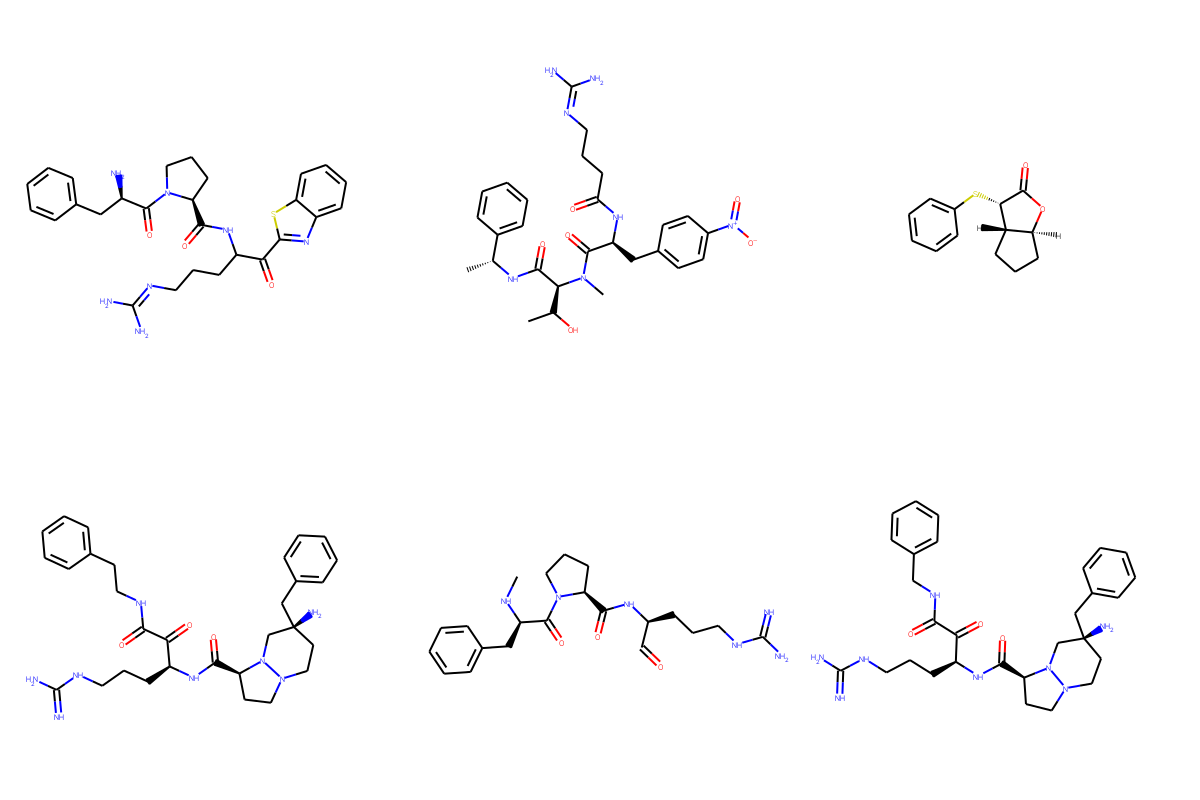

In [4]:
img = Draw.MolsToGridImage( actives[:6], molsPerRow=3, subImgSize=(400, 400))
img

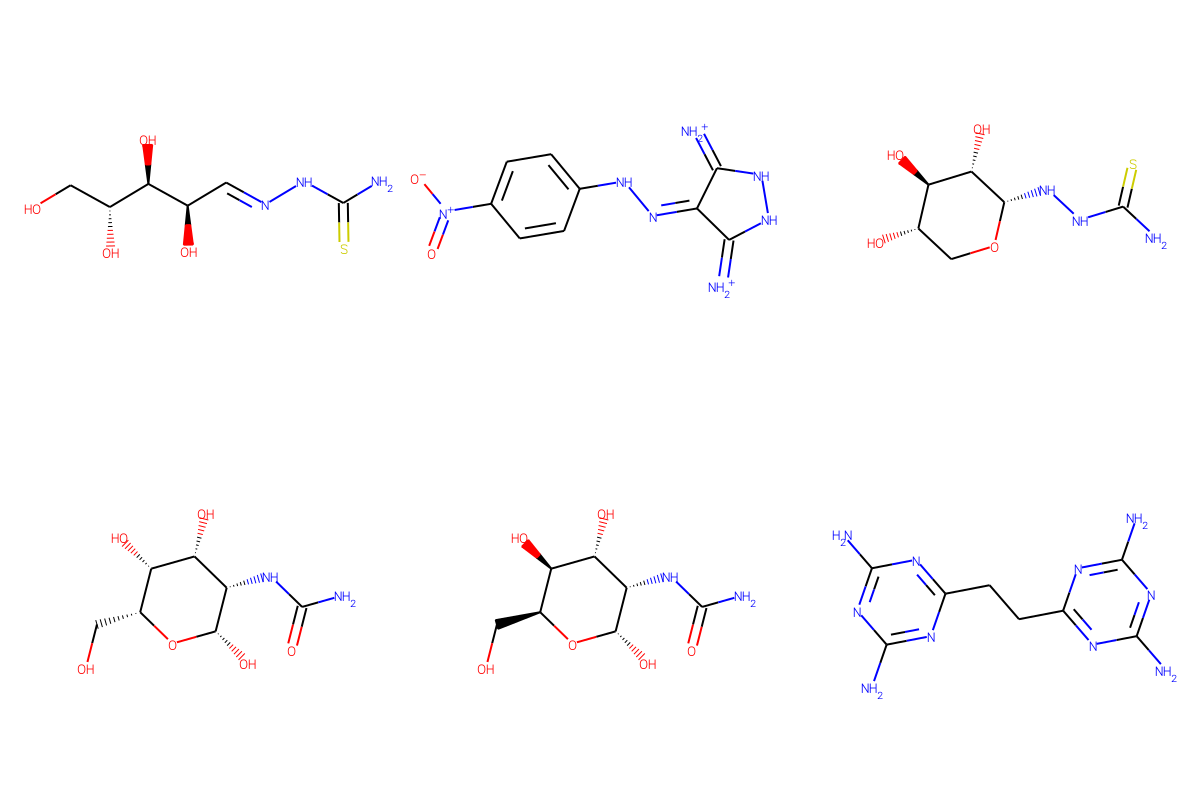

In [5]:
img = Draw.MolsToGridImage( decoys[:6], molsPerRow=3, subImgSize=(400, 400))
img

We need to generate properties for each molecule in the actives and decoy testing sets

In [6]:
mol = pd.Series(decoys + actives)
target_classes = np.array(['DECOY', 'ACTIVE'])
mol_labels = pd.Series(([target_classes[0]] * n) + ([target_classes[1]] * n))
df = pd.DataFrame()
df['molecule'] = mol
df['class'] = mol_labels
df['mol_weight'] = [ Descriptors.MolWt(m) for m in df['molecule'] ]
df['rot_bonds'] =  [ Descriptors.NumRotatableBonds(m) for m in df['molecule'] ]
df['h_donors'] =   [ Descriptors.NumHDonors(m) for m in df['molecule'] ]
df['h_acceptors'] = [ Descriptors.NumHAcceptors(m) for m in df['molecule'] ]
df['log_p'] = [ Descriptors.MolLogP(m) for m in df['molecule'] ]
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
df

,molecule,class,mol_weight,rot_bonds,h_donors,h_acceptors,log_p,is_train
0,<rdkit.Chem.rdchem.Mol object at 0x7f61dc6693a0>,DECOY,223.254,5,6,6,-3.11960,True
1,<rdkit.Chem.rdchem.Mol object at 0x7f61dc6693f0>,DECOY,249.234,3,5,4,-3.21430,True
2,<rdkit.Chem.rdchem.Mol object at 0x7f61dc669440>,DECOY,223.254,2,6,6,-3.23680,True
3,<rdkit.Chem.rdchem.Mol object at 0x7f61dc669490>,DECOY,222.197,2,6,6,-3.54540,True
4,<rdkit.Chem.rdchem.Mol object at 0x7f61dc6694e0>,DECOY,222.197,2,6,6,-3.54540,False
5,<rdkit.Chem.rdchem.Mol object at 0x7f61dc669530>,DECOY,248.254,3,4,10,-1.82940,True
6,<rdkit.Chem.rdchem.Mol object at 0x7f61dc669580>,DECOY,222.197,2,6,6,-3.54540,False
7,<rdkit.Chem.rdchem.Mol object at 0x7f61dc6695d0>,DECOY,342.297,4,8,11,-5.39720,True
8,<rdkit.Chem.rdchem.Mol object at 0x7f61dc669620>,DECOY,232.328,4,4,2,-2.33320,True
9,<rdkit.Chem.rdchem.Mol object at 0x7f61dc669670>,DECOY,322.334,3,8,8,-5.23910,True


In [7]:
train, test = df[df['is_train'] == True], df[df['is_train'] == False]

In [8]:
train.head()

,molecule,class,mol_weight,rot_bonds,h_donors,h_acceptors,log_p,is_train
0,<rdkit.Chem.rdchem.Mol object at 0x7f61dc6693a0>,DECOY,223.254,5,6,6,-3.1196,True
1,<rdkit.Chem.rdchem.Mol object at 0x7f61dc6693f0>,DECOY,249.234,3,5,4,-3.2143,True
2,<rdkit.Chem.rdchem.Mol object at 0x7f61dc669440>,DECOY,223.254,2,6,6,-3.2368,True
3,<rdkit.Chem.rdchem.Mol object at 0x7f61dc669490>,DECOY,222.197,2,6,6,-3.5454,True
5,<rdkit.Chem.rdchem.Mol object at 0x7f61dc669530>,DECOY,248.254,3,4,10,-1.8294,True


In [9]:
test.head()

,molecule,class,mol_weight,rot_bonds,h_donors,h_acceptors,log_p,is_train
4,<rdkit.Chem.rdchem.Mol object at 0x7f61dc6694e0>,DECOY,222.197,2,6,6,-3.5454,False
6,<rdkit.Chem.rdchem.Mol object at 0x7f61dc669580>,DECOY,222.197,2,6,6,-3.5454,False
10,<rdkit.Chem.rdchem.Mol object at 0x7f61dc6696c0>,DECOY,249.219,4,5,7,-5.2955,False
19,<rdkit.Chem.rdchem.Mol object at 0x7f61dc669990>,DECOY,326.298,3,7,10,-4.3696,False
26,<rdkit.Chem.rdchem.Mol object at 0x7f61dc669bc0>,DECOY,213.265,5,4,6,-1.4179,False


In [10]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 286
Number of observations in the test data: 114


In [11]:
features = df.columns[2:7]

# View features names
features

Index(['mol_weight', 'rot_bonds', 'h_donors', 'h_acceptors', 'log_p'], dtype='object')

In [12]:
y = pd.factorize(train['class'])
y # training classes

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 Index(['DECOY', 'ACTIVE'], dtype='o

In [13]:
clf = RandomForestClassifier(n_estimators=100)

If you want a (Gaussian) Naive Bayes instead ...

```python
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
```

In [14]:
model = clf.fit(train[features], y[0])

In [15]:
predictions = clf.predict(test[features])
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0])

In [16]:
clf.predict_proba(test[features])[:10]

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.99, 0.01],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.8 , 0.2 ],
       [0.99, 0.01]])

In [17]:
preds = target_classes[predictions]
preds

array(['DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY',
       'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY',
       'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY',
       'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY',
       'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'ACTIVE',
       'DECOY', 'DECOY', 'ACTIVE', 'DECOY', 'DECOY', 'DECOY', 'DECOY',
       'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY',
       'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY', 'DECOY',
       'DECOY', 'DECOY', 'ACTIVE', 'ACTIVE', 'DECOY', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'DECOY', 'ACTIVE', 'ACTIVE', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'ACTIVE', 'AC

In [18]:
# confusion matrix
pd.crosstab(test['class'], preds, rownames=['Actual Class'], colnames=['Predicted Class'])

Predicted Class,ACTIVE,DECOY
Actual Class,,
ACTIVE,53,3
DECOY,2,56


In [19]:
from sklearn import metrics
# accuracy
accuracy_score = metrics.accuracy_score(test['class'], preds)
print(accuracy_score)
# f1 score
f1_score = metrics.f1_score(test['class'], preds, pos_label="ACTIVE")
print(f1_score)

0.956140350877193
0.9549549549549549


Average precision-recall score: 0.94


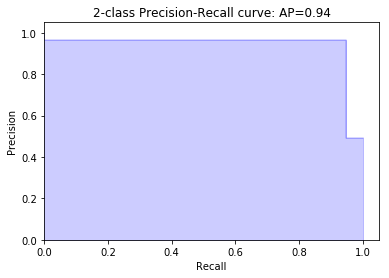

In [20]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

numeric_preds = [1 if cls == "ACTIVE" else 0 for cls in test['class']]

precision, recall, _ = precision_recall_curve(numeric_preds, predictions)

average_precision = average_precision_score(numeric_preds, predictions)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt;


In [21]:
list(zip(train[features], clf.feature_importances_))

[('mol_weight', 0.367688859463916),
 ('rot_bonds', 0.11060233939129203),
 ('h_donors', 0.04855167797047605),
 ('h_acceptors', 0.2457637586235898),
 ('log_p', 0.22739336455072606)]

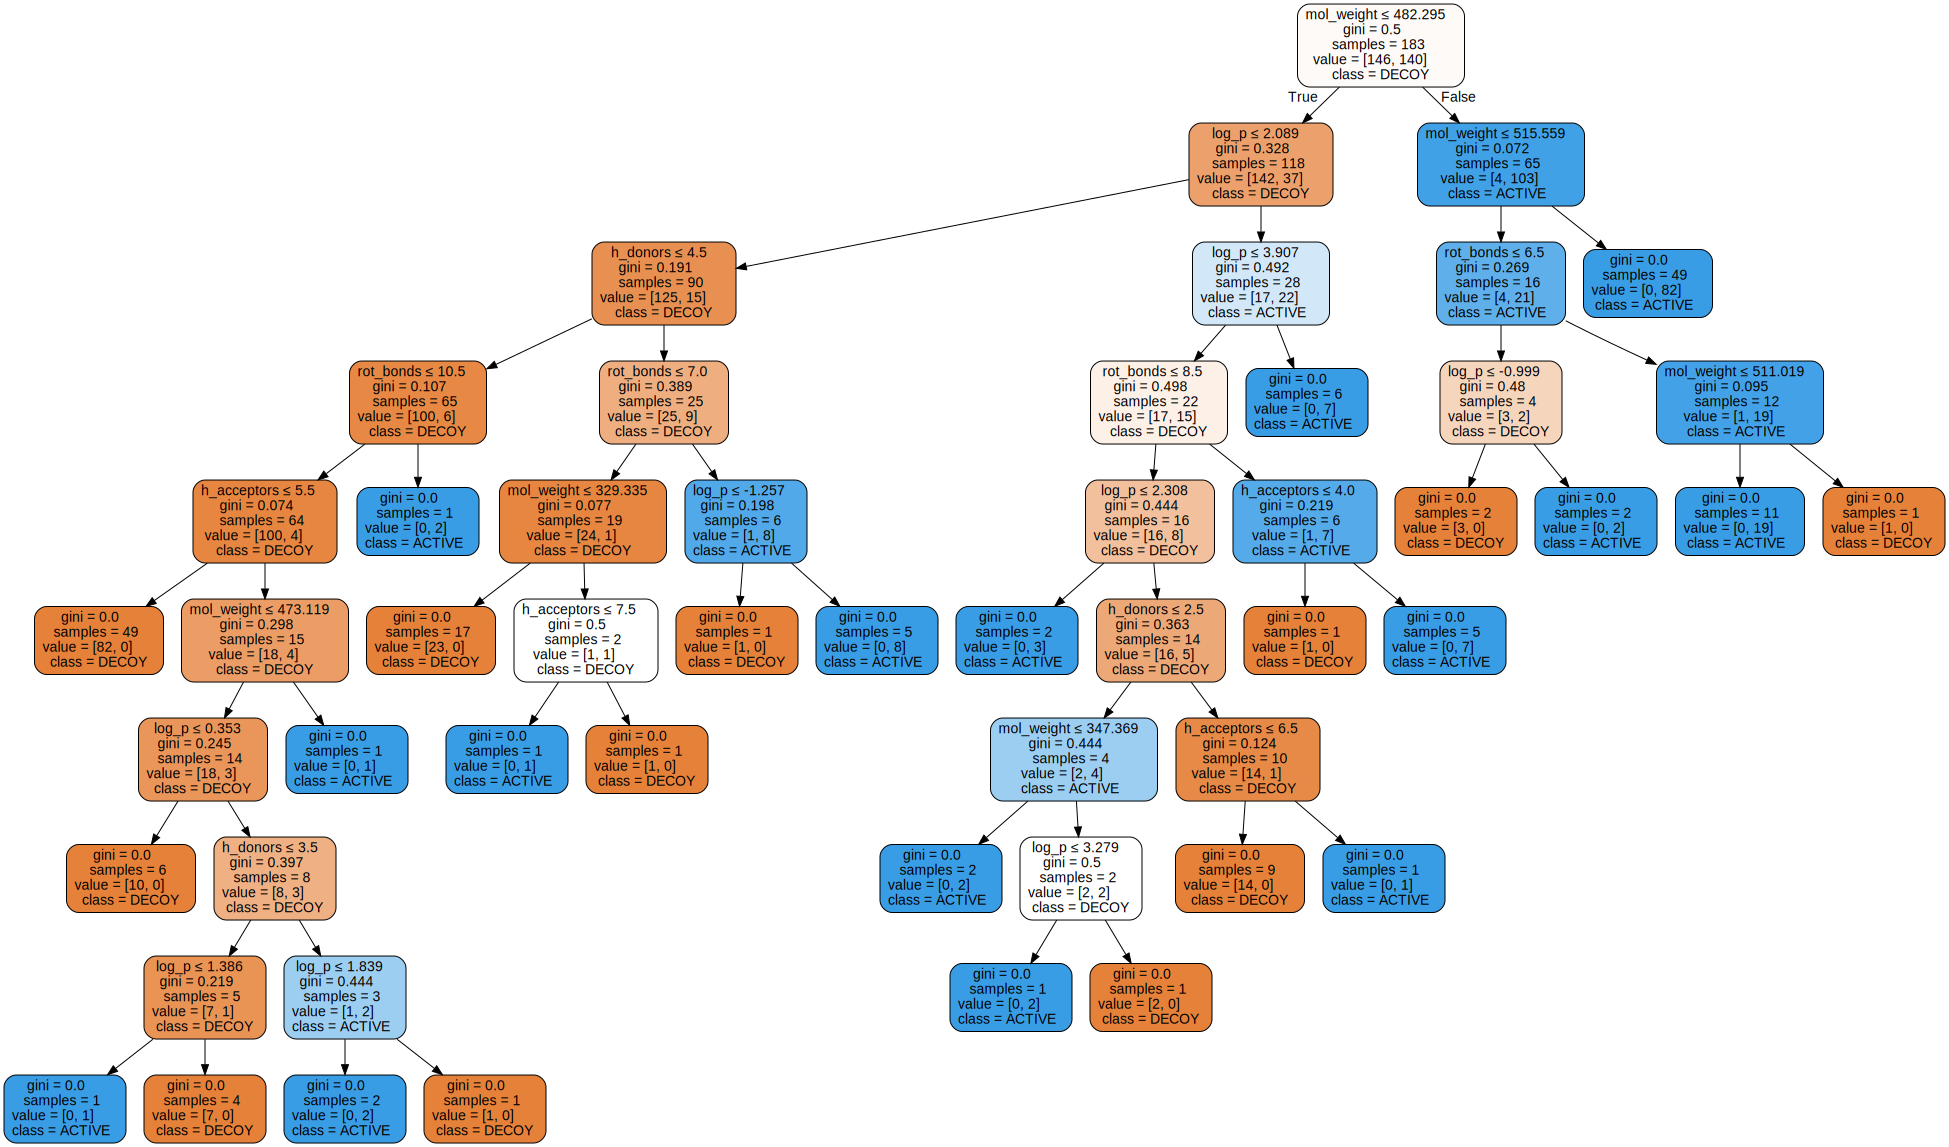

In [22]:
from sklearn import tree
import graphviz

# just one three for an example
trees =  [estimator for estimator in clf.estimators_]
single_tree = trees[0]

dot_data = tree.export_graphviz(single_tree, out_file=None, 
                         feature_names=features,  
                         class_names=target_classes,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 


# Practical Tasks

You are required to:

* Compute Accuracy of Model (plot a ROC curve)
* Build a Naive Bayes Classifier Model
* Test the models on more data (what is the accuracy?)
* Investigate the use of more training data
* Investigate the use of unbalanced sets for 
    1. Training
    2. Testing
